# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Педченко Андрей Николаевич`

Группа: `MADE-ML-32`

In [1]:
!apt install libspatialindex-dev
!pip install rtree
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (628 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

In [2]:
!pip install geopandas
!pip install osmapi
!pip install OSMPythonTools
!pip install earthpy
!pip install folium

  Created wheel for osmapi: filename=osmapi-1.3.0-cp36-none-any.whl size=13228 sha256=3e37ed4f1b1fe68ea12acd49d10187549b45070d1b938e69ba7b5993e5f05f6d
  Stored in directory: /root/.cache/pip/wheels/2c/ce/bb/177779128309a003ebeb34cc3b9464ec9111b4cd7886a61933
Successfully built osmapi
     |████████████████████████████████| 184kB 5.6MB/s 
  Created wheel for OSMPythonTools: filename=OSMPythonTools-0.2.9-cp36-none-any.whl size=12770 sha256=0f6e8429f6998e71d5a57dc235bfd146dc669e7cb387223858cc194be9778bef
  Stored in directory: /root/.cache/pip/wheels/4e/65/34/afe0b46e3dbb1b3da010967781d4999084bfe5c63d7b2eeefd
  Created wheel for pytest-sugar: filename=pytest_sugar-0.9.4-py2.py3-none-any.whl size=8972 sha256=d6bec8a30d2f5b01c6258efe0147ad67ddb45aa9e37bff9ae05075f22a0a88ae
  Stored in directory: /root/.cache/pip/wheels/72/ac/7f/55050ee786fa4a2bb2d05dea0696eab826ff1d5b8a7dbd5883
Successfully built OSMPythonTools pytest-sugar
     |████████████████████████████████| 1.4MB 2.8MB/s 
  Installing 

In [7]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import TimestampedGeoJson

from matplotlib.ticker import ScalarFormatter
import seaborn as sns

import pandas as pd
import numpy as np

import random
from shapely.geometry import LineString, Point, box, Polygon

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [ ]:
# put your code here

# Парсить полигон из OSM было слишком долго, поэтому беру встроенный

# https://geopandas.org/mapping.html
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
afghanistan = world.loc[world['name']=="Afghanistan"]
afghanistan

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
103,34124811,Asia,Afghanistan,AFG,64080.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."


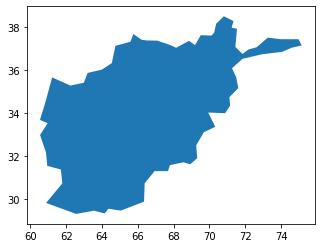

In [ ]:
afghanistan.geometry.plot()

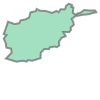

In [ ]:
searching_polygon = afghanistan['geometry'][0:1].values[0]
searching_polygon

Рандомный поиск

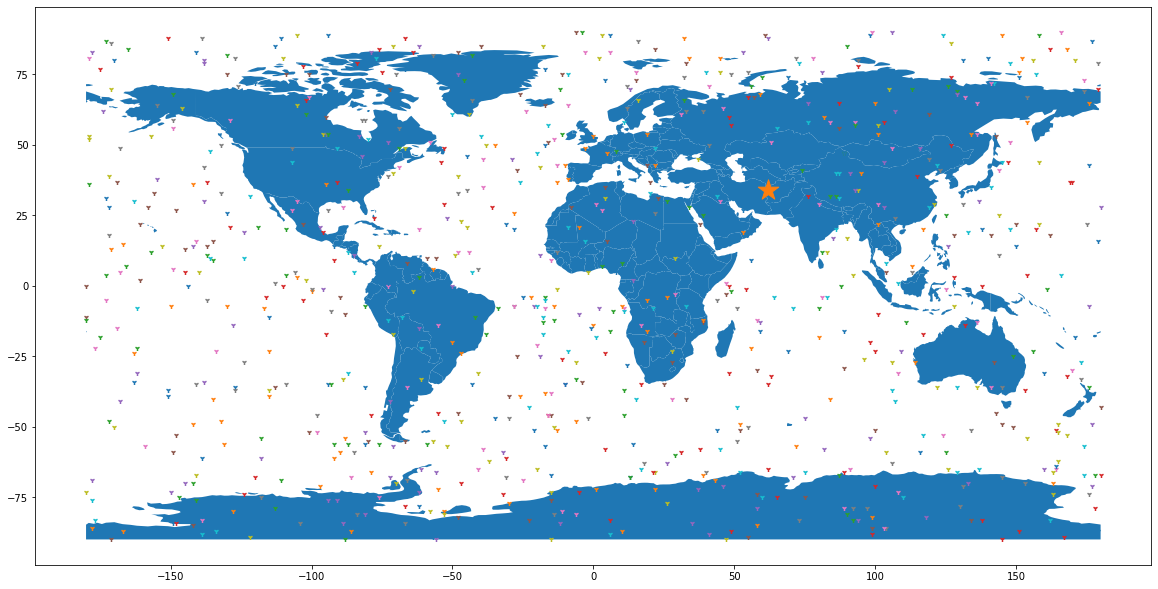

In [ ]:
fig, ax = plt.subplots(figsize=(20, 40))
world.plot(ax=ax)

flag = False
while not flag:
  random_point = Point(random.randint(-180, 180), random.randint(-90, 90))
  gdf_random_point = gpd.GeoDataFrame({'geometry': [random_point]})
  gdf_random_point.plot(ax=ax, markersize=25, marker='1')
  flag = random_point.within(searching_polygon)
gdf_random_point.plot(ax=ax, markersize=460, marker='*')

In [ ]:
gdf_random_point

,geometry
0,POINT (62.00000 34.00000)


Алгоритм не наивный

Узнаем площадь Афганистана, из центра карты начинаем строить квадраты, каждый раз расширяя их на половину площади страны. Как только появляется пересечение границы, находим центроид полигона от пересечения страны и последнего квадрата.
Это и есть искомая точка.

True

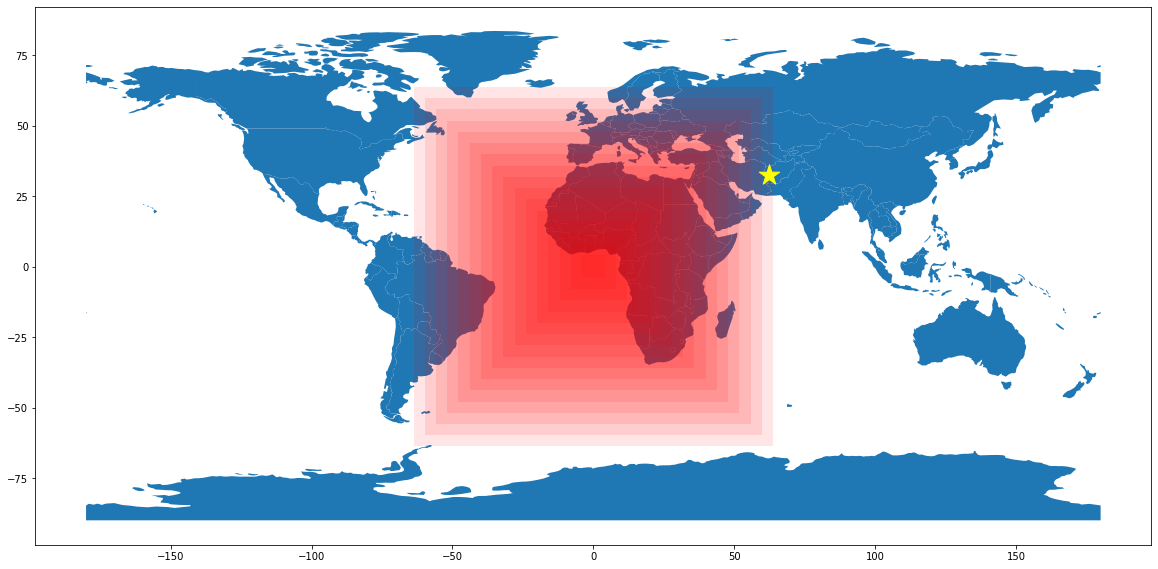

In [ ]:
step = np.sqrt(searching_polygon.area) / 2

fig, ax = plt.subplots(figsize=(20, 40))
world.plot(ax=ax)

x1 = y3 = x4 = y4 = step
y1 = x2 = y2 = x3 = -step

boxes = gpd.GeoDataFrame()
boxes['geometry'] = None
index = 0
lines = []

flag = False
while not flag:
  random_box = Polygon([(x1, y1), (x2, y2),
                      (x3, y3), (x4, y4)])
  boxes.loc[index, 'geometry'] = random_box
  gdf_random_box = gpd.GeoDataFrame({'geometry': [random_box]})
  gdf_random_box.plot(ax=ax, alpha = 0.1, color = 'red')
  flag = random_box.intersects(searching_polygon)

  # Не нашел, как в фолиуме нормально визуализировать набор полигонов, поэтому каждый бокс делю на линии и визуализирую потом линии
  if index < 9:
    lines.append({'coordinates': [[x1, y1], [x2, y2]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:0{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x2, y2], [x3, y3]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:0{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x3, y3], [x4, y4]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:0{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x4, y4], [x1, y1]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:0{t}:00'.format(t=index+1)]})
  elif index == 9:
    lines.append({'coordinates': [[x1, y1], [x2, y2]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x2, y2], [x3, y3]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x3, y3], [x4, y4]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x4, y4], [x1, y1]], 'dates': ['2017-06-02T00:0{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})
  elif index > 9:
    lines.append({'coordinates': [[x1, y1], [x2, y2]], 'dates': ['2017-06-02T00:{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x2, y2], [x3, y3]], 'dates': ['2017-06-02T00:{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x3, y3], [x4, y4]], 'dates': ['2017-06-02T00:{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})
    lines.append({'coordinates': [[x4, y4], [x1, y1]], 'dates': ['2017-06-02T00:{t}:00'.format(t=index), '2017-06-02T00:{t}:00'.format(t=index+1)]})

  x1 = y3 = x4 = y4 = x1 + step
  y1 = x2 = y2 = x3 = y1 - step
  index += 1

intersec_poly = random_box.intersection(searching_polygon)
searching_point = Point(intersec_poly.centroid.x, intersec_poly.centroid.y)
gdf_searching_point = gpd.GeoDataFrame({'geometry': [searching_point]})
gdf_searching_point.plot(ax=ax, markersize=460, color = 'yellow', marker='*')
searching_point.within(searching_polygon)

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [ ]:
m = folium.Map(location=[0, 0], zoom_start=3)

folium.GeoJson(searching_polygon).add_to(m)

features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': 'red',
                'weight':  5
            }
        }
    }
    for line in lines
]

TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT1M', add_last_point=True).add_to(m)

folium.Marker(location=[searching_point.coords[0][1], searching_point.coords[0][0]], icon=folium.Icon(color = 'green'), popup='<b>Afghanistan</b>').add_to(m)

m

In [ ]:
m = folium.Map(location=[0, 0], zoom_start=3)

folium.GeoJson(searching_polygon).add_to(m)

for index, row in boxes.iterrows():
  folium.GeoJson(boxes['geometry'].iloc[index]).add_to(m)

folium.Marker(location=[searching_point.coords[0][1], searching_point.coords[0][0]], icon=folium.Icon(color = 'green'), popup='<b>Afghanistan</b>').add_to(m)

m

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

1. Расстояние от точки до 5 ближайших * банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости

In [ ]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
# put your code here

from OSMPythonTools.overpass import overpassQueryBuilder
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import Overpass
import tqdm
import traceback

overpass = Overpass()

countries = world.name.unique()

countries_stat = {}

for country in tqdm.tqdm_notebook(countries):

  nominatim = Nominatim()
  areaId = nominatim.query(country).areaId()
  try:
    if areaId % 10 == 0:
      print (areaId, country)
      query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector='"building"~"apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|static_caravan"', out='count') # selector='"building"="yes"' 
      result = overpass.query(query, timeout=500).countElements()
      countries_stat[country] = result
    else:
      continue
  except TypeError:
    continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


3600195270 Tanzania
3600196240 Uzbekistan
3602978650 Norway
[overpass] downloading data: [timeout:500][out:json];area(3602978650)->.searchArea;(node["building"~"apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|static_caravan"](area.searchArea);way["building"~"apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|static_caravan"](area.searchArea);relation["building"~"apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|static_caravan"](area.searchArea);); out count;
3600059470 Brazil
[overpass] downloading data: [timeout:500][out:json];area(3600059470)->.searchArea;(node["building"~"apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|static_caravan"](area.searchArea);way["building"~"apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|static_caravan"](area.searchArea);relation["building"~"apartments|bungalow|detached|dormitory|farm|ger|hotel|house|residential|static_caravan"](area.searchAr

In [ ]:
countries_stat

{'Australia': 585168,
 'Azerbaijan': 22217,
 'Bangladesh': 50175,
 'Brazil': 764935,
 'Brunei': 14618,
 'Cameroon': 22111,
 'Estonia': 10499,
 'Ethiopia': 11339,
 'Honduras': 33123,
 'Kosovo': 24290,
 'Liberia': 54826,
 'Malawi': 97814,
 'Norway': 307222,
 'Portugal': 278234,
 'Syria': 13757,
 'Tanzania': 314699,
 'Uzbekistan': 43080,
 'eSwatini': 7313}

In [ ]:
# Больше всего зданий в Brazil, поэтому банкоматы ищем в ней

nominatim = Nominatim()
areaId = nominatim.query('Brazil').areaId()
query = overpassQueryBuilder(area=areaId, elementType=['node'], selector='"amenity"="atm"', out='meta')
result = overpass.query(query, timeout=500)

[nominatim] downloading data: Brazil
[overpass] downloading data: [timeout:500][out:json];area(3600059470)->.searchArea;(node["amenity"="atm"](area.searchArea);); out meta;


In [ ]:
from scipy import spatial
tree = spatial.KDTree([el.geometry()["coordinates"] for el in result.elements()])
tree_result = tree.query(np.array([[searching_point.x, searching_point.y]]), k=5)

In [ ]:
detected_dots = []
for el in tree_result[1][0]:
  detected_dots.append(Point(tree.data[el]))
detected_dots

In [ ]:
from math import radians, cos, sin, asin, sqrt

# Из интернета взял
def haversine(lat1, lon1, lat2, lon2):
  """
  Вычисляет расстояние в километрах между двумя точками, учитывая окружность Земли.
  https://en.wikipedia.org/wiki/Haversine_formula
  """

  # convert decimal degrees to radians
  lon1, lat1, lon2, lat2 = map(radians, (lon1, lat1, lon2, lat2))

  # haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * asin(sqrt(a))
  km = 6367 * c
  return km

dist_1 = 0
for p in detected_dots:
  dist_1 += haversine(searching_point.x, searching_point.y, p.x, p.y)
dist_1 /= 5
print("Среднее расстояние до 5 ближайших банкоматов в Бразилии", dist_1, 'км') # Это ответ на первый пункт
# Похоже на правду

Среднее расстояние до 5 ближайших банкоматов в Бразилии 11029.707937494706 км


Text(0.5, 1.0, 'Банкоматы Бразилии. Красные точки — это все банкоматы страны, зеленые точки — это искомая пятёрка')

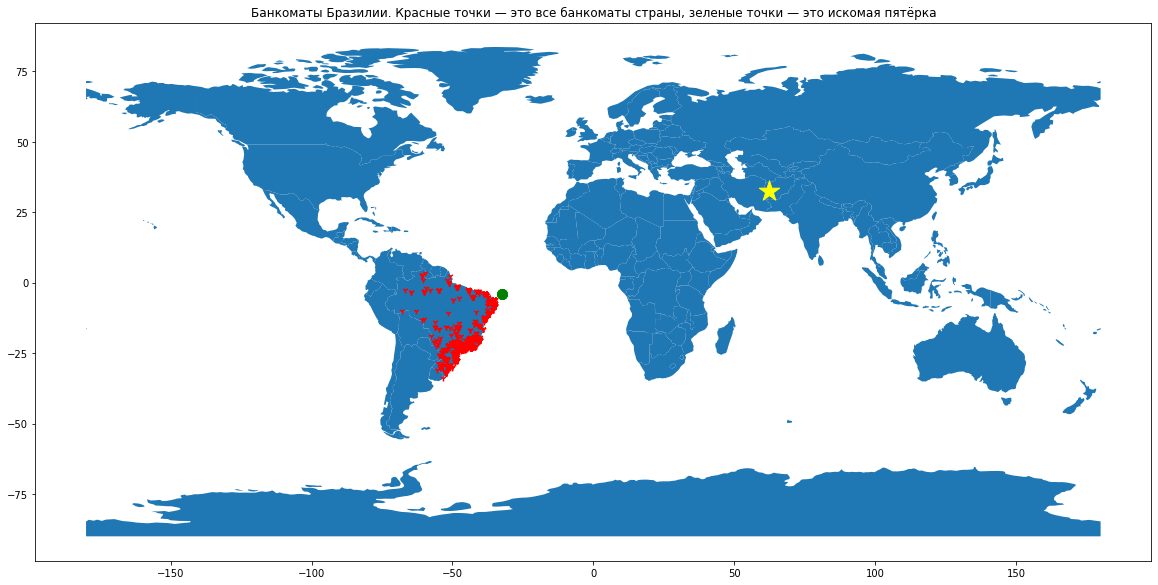

In [ ]:
all_atms = gpd.GeoDataFrame()
all_atms['geometry'] = None
for index in range(len(result.elements())):
  all_atms.loc[index, 'geometry'] = Point(result.elements()[index].geometry()["coordinates"])

gdf_detected_dots = gpd.GeoDataFrame()
gdf_detected_dots['geometry'] = None
for index, elem in enumerate(detected_dots):
  gdf_detected_dots.loc[index, 'geometry'] = elem

fig, ax = plt.subplots(figsize=(20, 40))
world.plot(ax=ax)

all_atms.plot(ax=ax, markersize=35, color = 'red', marker='1')
gdf_detected_dots.plot(ax=ax, markersize=375, color = 'green', marker='.')
gdf_searching_point = gpd.GeoDataFrame({'geometry': [searching_point]})
gdf_searching_point.plot(ax=ax, markersize=460, color = 'yellow', marker='*')
ax.set_title('Банкоматы Бразилии. Красные точки — это все банкоматы страны, зеленые точки — это искомая пятёрка')

Может показаться, что найденные банкоматы находятся в океане, но там есть микроостров.

Попробуем другой алгоритм поиска ближайших точек *R-Tree*

Среднее расстояние до 5 ближайших банкоматов в Бразилии 11029.707937494706 км 


Ответ совпадает с ответом выше




Text(0.5, 1.0, 'Банкоматы Бразилии. Красные точки — это все банкоматы страны, зеленые точки — это искомая пятёрка')

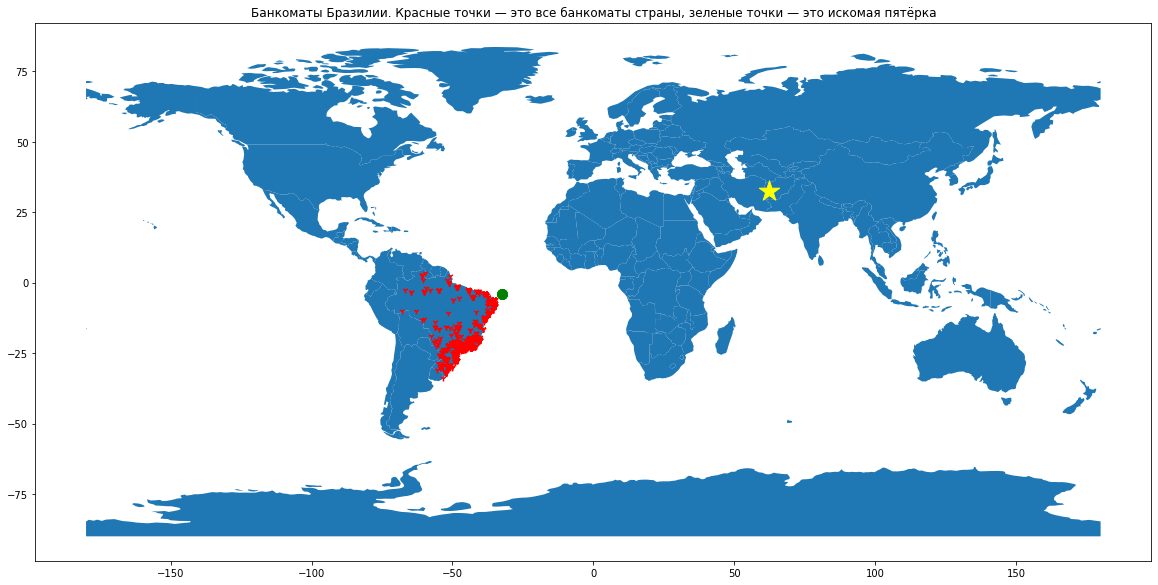

In [ ]:
from rtree import index

file_idx = index.Rtree()
for i, atm in enumerate([el.geometry()["coordinates"] for el in result.elements()]):
  file_idx.insert(i, atm + atm, atm)

detected_dots2 = list(file_idx.nearest([searching_point.coords[0][1], searching_point.coords[0][0]], 5, objects='raw'))

gdf_detected_dots2 = gpd.GeoDataFrame()
gdf_detected_dots2['geometry'] = None
for index, elem in enumerate(detected_dots2):
  gdf_detected_dots2.loc[index, 'geometry'] = Point(elem[0], elem[1])

dist_1 = 0
for p in detected_dots2:
  dist_1 += haversine(searching_point.x, searching_point.y, p[0], p[1])
dist_1 /= 5
print("Среднее расстояние до 5 ближайших банкоматов в Бразилии", dist_1, 'км', '\n\n')

print('Ответ совпадает с ответом выше' '\n\n')

fig, ax = plt.subplots(figsize=(20, 40))
world.plot(ax=ax)

all_atms.plot(ax=ax, markersize=35, color = 'red', marker='1')
gdf_detected_dots2.plot(ax=ax, markersize=375, color = 'green', marker='.')
gdf_searching_point = gpd.GeoDataFrame({'geometry': [searching_point]})
gdf_searching_point.plot(ax=ax, markersize=460, color = 'yellow', marker='*')
ax.set_title('Банкоматы Бразилии. Красные точки — это все банкоматы страны, зеленые точки — это искомая пятёрка')

2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице

In [ ]:
!wget https://gist.githubusercontent.com/rpbaltazar/c9a57e115dacaa4f38a94a12d9b63e5c/raw/f69b39ff1696d3ba62ae315058cf4f6e17ae81d9/world_capitals.csv
df_cap = pd.read_csv('world_capitals.csv', header = None)
df_cap.columns = ['cap']
capitals = df_cap.cap.unique()

--2020-10-24 15:43:58--  https://gist.githubusercontent.com/rpbaltazar/c9a57e115dacaa4f38a94a12d9b63e5c/raw/f69b39ff1696d3ba62ae315058cf4f6e17ae81d9/world_capitals.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2254 (2.2K) [text/plain]
Saving to: ‘world_capitals.csv.3’

world_capitals.csv. 100%[===================>]   2.20K  --.-KB/s    in 0s      

2020-10-24 15:43:58 (40.8 MB/s) - ‘world_capitals.csv.3’ saved [2254/2254]



In [ ]:
capitals_stat = {}

for metropolis in tqdm.tqdm_notebook(capitals):
  try:
    overpass = Overpass()
    nominatim = Nominatim()
    areaId = nominatim.query(metropolis).areaId()
    query1 = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector='"amenity"="pharmacy"', out='count')
    result1 = overpass.query(query1, timeout=500).countElements()
    query2 = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector='"shop"="chemist"', out='count')
    result2 = overpass.query(query2, timeout=500).countElements()
    capitals_stat[metropolis] = result1 + result2
  except:
    continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


[nominatim] downloading data: Abu Dhabi
[overpass] downloading data: [timeout:500][out:json];area(3604479763)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);way["amenity"="pharmacy"](area.searchArea);relation["amenity"="pharmacy"](area.searchArea);); out count;
[overpass] downloading data: [timeout:500][out:json];area(3604479763)->.searchArea;(node["shop"="chemist"](area.searchArea);way["shop"="chemist"](area.searchArea);relation["shop"="chemist"](area.searchArea);); out count;
[nominatim] downloading data: Adamstown
[overpass] downloading data: [timeout:500][out:json];area(3600188845)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);way["amenity"="pharmacy"](area.searchArea);relation["amenity"="pharmacy"](area.searchArea);); out count;
[overpass] downloading data: [timeout:500][out:json];area(3600188845)->.searchArea;(node["shop"="chemist"](area.searchArea);way["shop"="chemist"](area.searchArea);relation["shop"="chemist"](area.searchArea);); out count;
[nominatim] 

In [ ]:
# Снова работаем с Бразилией
import operator
print(max(capitals_stat.items(), key=operator.itemgetter(1))[0], '\n')
print(capitals_stat[max(capitals_stat.items(), key=operator.itemgetter(1))[0]])

Brasília 

9048


In [ ]:
nominatim = Nominatim()
areaId = nominatim.query('Brazil').areaId()
query = overpassQueryBuilder(area=areaId, elementType=['node'], selector='"amenity"~".*school|school.*"', out='meta')
result = overpass.query(query, timeout=500)

tree = spatial.KDTree([el.geometry()["coordinates"] for el in result.elements()])
tree_result = tree.query(np.array([[searching_point.x, searching_point.y]]), k=5)

detected_dots = []
for el in tree_result[1][0]:
  detected_dots.append(Point(tree.data[el]))

dist_1 = 0
for p in detected_dots:
  dist_1 += haversine(searching_point.x, searching_point.y, p.x, p.y)
dist_1 /= 5
print("Среднее расстояние до 5 ближайших школ в Бразилии", dist_1, 'км') # Это ответ на второй пункт

[overpass] downloading data: [timeout:500][out:json];area(3600059470)->.searchArea;(node["amenity"~".*school|school.*"](area.searchArea);); out meta;
Среднее расстояние до 5 ближайших школ в Бразилии 11376.25035131508 км


In [ ]:
# Пробуем второй алгоритм

from rtree import index

file_idx = index.Rtree()
for i, school in enumerate([el.geometry()["coordinates"] for el in result.elements()]):
  file_idx.insert(i, school + school, school)

detected_dots2 = list(file_idx.nearest([searching_point.coords[0][1], searching_point.coords[0][0]], 5, objects='raw'))

gdf_detected_dots2 = gpd.GeoDataFrame()
gdf_detected_dots2['geometry'] = None
for index, elem in enumerate(detected_dots2):
  gdf_detected_dots2.loc[index, 'geometry'] = Point(elem[0], elem[1])

dist_1 = 0
for p in detected_dots2:
  dist_1 += haversine(searching_point.x, searching_point.y, p[0], p[1])
dist_1 /= 5
print("Среднее расстояние до 5 ближайших банкоматов в Бразилии", dist_1, 'км', '\n\n')

print('Ответ отличается от предыдущего на 1 км, так что норм.' '\n\n')

Среднее расстояние до 5 ближайших банкоматов в Бразилии 11377.28166690334 км 


Ответ отличается от предыдущего на 1 км, так что норм.




Text(0.5, 1.0, 'Школы Бразилии. Красные точки — это все школы страны, зеленые точки — это искомая пятёрка')

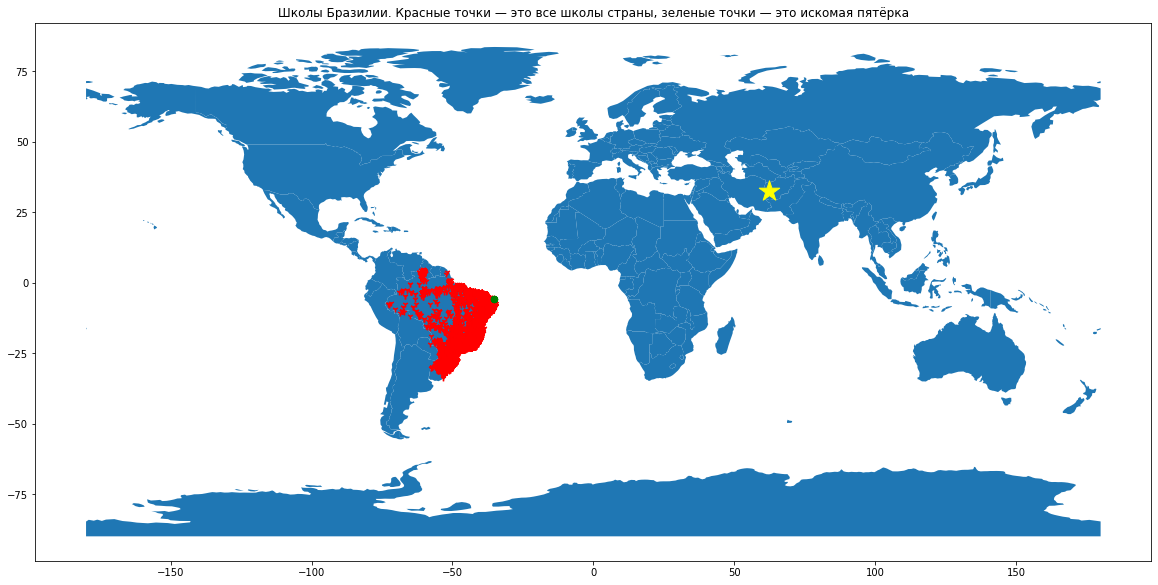

In [ ]:
all_schools = gpd.GeoDataFrame()
all_schools['geometry'] = None
for index in range(len(result.elements())):
  all_schools.loc[index, 'geometry'] = Point(result.elements()[index].geometry()["coordinates"])

fig, ax = plt.subplots(figsize=(20, 40))
world.plot(ax=ax)

all_schools.plot(ax=ax, markersize=35, color = 'red', marker='1')
gdf_detected_dots2.plot(ax=ax, markersize=155, color = 'green', marker='.')
gdf_searching_point = gpd.GeoDataFrame({'geometry': [searching_point]})
gdf_searching_point.plot(ax=ax, markersize=460, color = 'yellow', marker='*')
ax.set_title('Школы Бразилии. Красные точки — это все школы страны, зеленые точки — это искомая пятёрка')

3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

In [ ]:
from shapely import affinity
from shapely.ops import linemerge, unary_union, polygonize

def get_south_poly(some_poly):
  '''Берутся северная и южная точки полигона, строится отрезок, потом строится перпендикулярный отрезок.
    Находится пересечение отрезка и краев полигона. Строится полигон, отхватывающий южную часть до пересечения.
    Функция возвращает этот полигон. Потом при переборе точек по странам просто проверяется, принадлежит ли точка
    обрезанному полигону'''

  if some_poly.type == 'Polygon':

    coords = some_poly.exterior.coords.xy
    x_coords = coords[0]
    y_coords = coords[1]

  elif some_poly.type == 'MultiPolygon':

    x_coords = []
    y_coords = []
    for poly in some_poly:
      coords = poly.exterior.coords.xy
      xs = coords[0]
      ys = coords[1]
      for i in range(len(xs)):
        x_coords.append(xs[i])
        y_coords.append(ys[i])

  y_max = max(y_coords)
  y_max_index = y_coords.index(y_max)
  x_max = x_coords[y_max_index]
  
  y_min = min(y_coords)
  y_min_index = y_coords.index(y_min)
  x_min = x_coords[y_min_index]

  l1 = LineString([[x_max,y_max], [x_min,y_min]])
  l2 = affinity.rotate(l1, 90, origin='centroid')

  intersec_dots = some_poly.boundary.intersection(l2)
  dot1 = (intersec_dots[0].x, intersec_dots[0].y)
  dot2 = (intersec_dots[-1].x, intersec_dots[-1].y)

  left_max, low_max, right_max, up_max = searching_polygon.bounds

  if intersec_dots[0].y > intersec_dots[-1].y:
    x_min = min(x_coords)
    new_poly = Polygon([dot1, dot2, (dot2[0], y_min), (x_min, y_min), (x_min, dot1[1])])
  else:
    x_max = max(x_coords)
    new_poly = Polygon([dot1, dot2, (x_max, dot2[1]), (x_max, y_min), (dot1[0], y_min)])

  return new_poly

In [ ]:
country_stat = {}

for country in tqdm.tqdm_notebook(countries):
  try:
    country_poly = world.loc[world['name']==country]['geometry'][0:1].values[0]
    south_poly = get_south_poly(country_poly)

    res1_dots = 0
    res2_dots = 0

    overpass = Overpass()
    nominatim = Nominatim()
    areaId = nominatim.query(country).areaId()
    query1 = overpassQueryBuilder(area=areaId, elementType=['node'], selector='"railway"~"station|halt"', out='meta')
    result1 = overpass.query(query1, timeout=500)
    for el in result1.nodes():
      p = Point(el.lon(), el.lat())
      if p.within(south_poly):
        res1_dots += 1

    query2 = overpassQueryBuilder(area=areaId, elementType=['node'], selector='"highway"="bus_stop"', out='meta')
    result2 = overpass.query(query2, timeout=500)
    for el in result2.nodes():
      p = Point(el.lon(), el.lat())
      if p.within(south_poly):
        res2_dots += 1

    country_stat[country] = res1_dots / res2_dots
  except Exception as err:
    print(err)
    continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


'LineString' object does not support indexing
[nominatim] downloading data: W. Sahara
[overpass] downloading data: [timeout:500][out:json];area(3602559126)->.searchArea;(node["railway"~"station|halt"](area.searchArea);); out meta;
'NoneType' object is not iterable
[nominatim] downloading data: Canada
[overpass] downloading data: [timeout:500][out:json];area(3601428125)->.searchArea;(node["railway"~"station|halt"](area.searchArea);); out meta;
[overpass] downloading data: [timeout:500][out:json];area(3601428125)->.searchArea;(node["highway"="bus_stop"](area.searchArea);); out meta;
'LineString' object does not support indexing
'LineString' object does not support indexing
[nominatim] downloading data: Uzbekistan
[overpass] downloading data: [timeout:500][out:json];area(3600196240)->.searchArea;(node["railway"~"station|halt"](area.searchArea);); out meta;
[overpass] downloading data: [timeout:500][out:json];area(3600196240)->.searchArea;(node["highway"="bus_stop"](area.searchArea);); out

In [ ]:
country_stat

{'Afghanistan': 0.0,
 'Albania': 0.12598425196850394,
 'Angola': 37.5,
 'Argentina': 0.08189855746859004,
 'Armenia': 0.0,
 'Azerbaijan': 0.1704745166959578,
 'Bangladesh': 0.25526315789473686,
 'Benin': 0.8181818181818182,
 'Botswana': 0.00980392156862745,
 'Bulgaria': 0.18523002421307505,
 'Burkina Faso': 0.1,
 'Cameroon': 0.6041666666666666,
 'Canada': 0.01341507673164662,
 'Chile': 0.021066938498131158,
 'China': 0.14304064973273112,
 'Colombia': 0.001466275659824047,
 'Congo': 1.2698412698412698,
 'Costa Rica': 0.015065913370998116,
 'Croatia': 0.03769140164899882,
 'Cuba': 0.25232678386763185,
 'Ecuador': 0.014258555133079848,
 'Egypt': 1.3333333333333333,
 'El Salvador': 0.08695652173913043,
 'Ethiopia': 0.05,
 'Gabon': 2.0,
 'Ghana': 0.003305785123966942,
 'Guatemala': 0.0234192037470726,
 'Guinea': 0.5,
 'Hungary': 0.04756127153603494,
 'India': 0.24113333333333334,
 'Indonesia': 0.3076923076923077,
 'Iran': 0.11005135730007337,
 'Iraq': 0.6336633663366337,
 'Israel': 0.002587

In [ ]:
# import operator
print(max(country_stat.items(), key=operator.itemgetter(1))[0], '\n')
print(country_stat[max(country_stat.items(), key=operator.itemgetter(1))[0]])

Angola 

37.5


In [ ]:
# Наибольшее отношение в Анголе, но судя по цифрам в других странах, скорее всего что-то с разметкой этой страны

nominatim = Nominatim()
areaId = nominatim.query('Angola').areaId()
query = overpassQueryBuilder(area=areaId, elementType=['node'], selector='"amenity"="cinema"', out='meta')
result = overpass.query(query, timeout=500)

tree = spatial.KDTree([el.geometry()["coordinates"] for el in result.elements()])
tree_result = tree.query(np.array([[searching_point.x, searching_point.y]]), k=5)

detected_dots = []
for el in tree_result[1][0]:
  detected_dots.append(Point(tree.data[el]))

dist_1 = 0
for p in detected_dots:
  dist_1 += haversine(searching_point.x, searching_point.y, p.x, p.y)
dist_1 /= 5
print("Среднее расстояние до 5 ближайших кинотеатров в Анголе", dist_1, 'км') # Это ответ на третий пункт, похоже на правду

[overpass] downloading data: [timeout:500][out:json];area(3600195267)->.searchArea;(node["amenity"="cinema"](area.searchArea);); out meta;
Среднее расстояние до 5 ближайших кинотеатров в Анголе 6359.54908650648 км


In [ ]:
# Пробуем второй алгоритм

from rtree import index

file_idx = index.Rtree()
for i, cinema in enumerate([el.geometry()["coordinates"] for el in result.elements()]):
  file_idx.insert(i, cinema + cinema, cinema)

detected_dots2 = list(file_idx.nearest([searching_point.coords[0][1], searching_point.coords[0][0]], 5, objects='raw'))

gdf_detected_dots2 = gpd.GeoDataFrame()
gdf_detected_dots2['geometry'] = None
for index, elem in enumerate(detected_dots2):
  gdf_detected_dots2.loc[index, 'geometry'] = Point(elem[0], elem[1])

dist_1 = 0
for p in detected_dots2:
  dist_1 += haversine(searching_point.x, searching_point.y, p[0], p[1])
dist_1 /= 5
print("Среднее расстояние до 5 ближайших кинотеатров в Анголе", dist_1, 'км', '\n\n')

print('Ответ отличается от предыдущего на 2 км, так что норм.' '\n\n')

Среднее расстояние до 5 ближайших кинотеатров в Анголе 6361.3586008856355 км 


Ответ отличается от предыдущего на 2 км, так что норм.




Text(0.5, 1.0, 'Кинотеатры Анголы. Красные точки — это все кинотеатры страны, желтые точки — это искомая пятёрка')

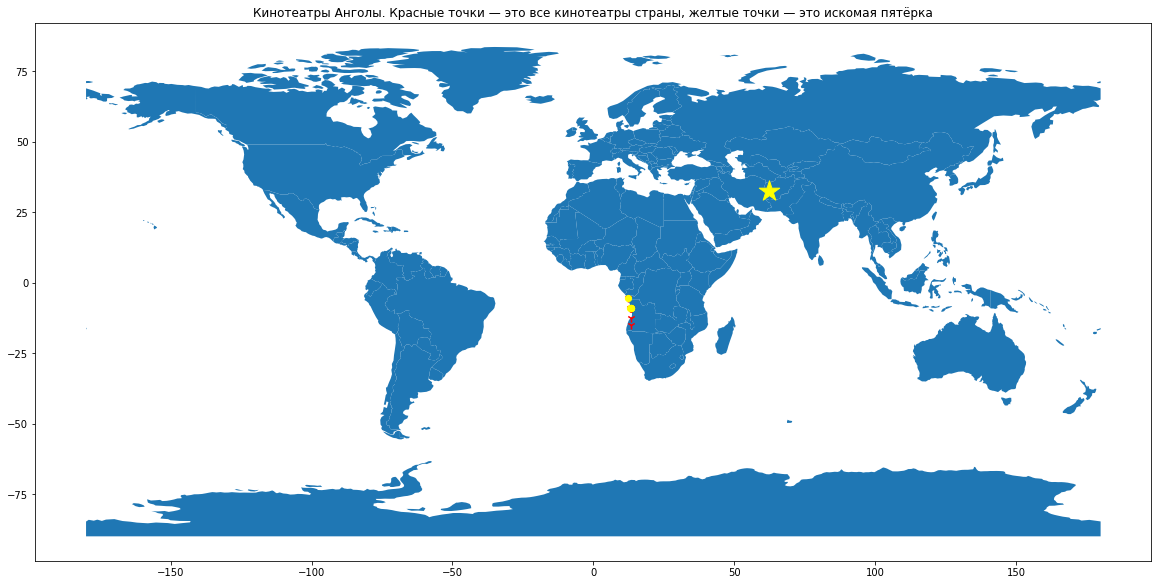

In [ ]:
all_cinemas = gpd.GeoDataFrame()
all_cinemas['geometry'] = None
for index in range(len(result.elements())):
  all_cinemas.loc[index, 'geometry'] = Point(result.elements()[index].geometry()["coordinates"])

fig, ax = plt.subplots(figsize=(20, 40))
world.plot(ax=ax, )

all_cinemas.plot(ax=ax, markersize=65, color = 'red', marker='1')
gdf_detected_dots2.plot(ax=ax, markersize=155, color = 'yellow', marker='.')
gdf_searching_point = gpd.GeoDataFrame({'geometry': [searching_point]})
gdf_searching_point.plot(ax=ax, markersize=460, color = 'yellow', marker='*')
ax.set_title('Кинотеатры Анголы. Красные точки — это все кинотеатры страны, желтые точки — это искомая пятёрка')

Если сложить числа, полученные в трех пунктах, получается 28 768,33 км.

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [4]:
!pip install openrouteservice

In [67]:
from openrouteservice import client
from shapely.geometry import mapping, MultiPolygon
from shapely.ops import cascaded_union
from shapely import geometry
import pyproj
import warnings
warnings.filterwarnings("ignore")

A = [40.7791200, -73.9626495] # Координаты входа в парк https://www.openstreetmap.org/node/5618087855
B = [40.7032046, -73.9895414] # Координаты перекрестка для фоточек https://www.openstreetmap.org/node/4524681290

# Загружал руками во времянку колаба
gdf_shool = gpd.read_file('2019_-_2020_School_Point_Locations.csv')

api_key = '5b3ce3597851110001cf624892614fd7b6ca4140b0ed346358373080'
clnt = client.Client(key=api_key)

coordinates = [[-73.9626495, 40.7791200], [-73.9895414, 40.7032046]]

In [68]:
m = folium.Map(location=[40.7791200, -73.9626495], zoom_start=12)

request_params = {'coordinates': coordinates,
                    'profile': 'driving-car', 
                    'format_out': 'geojson',
                    'preference': 'shortest',
                    'geometry': 'true'}

route_normal = clnt.directions(**request_params)

duration, distance = route_normal['features'][0]['properties']['summary'].values()

folium.GeoJson(route_normal).add_to(m)

folium.Marker(location=A, icon=folium.Icon(color = 'red'), popup='<b>Вход в парк</b>', tooltip='Start').add_to(m)
folium.Marker(location=B, icon=folium.Icon(color = 'green'), popup='<b>Перекресток</b>', tooltip='Finish').add_to(m)

m

In [76]:
# Если брать все школы из датафрейма, то будет окло 2 тыс точек, в таком случае
# маршрут строится очень долго, поэтому беру только 200 школ Бруклина или Манхеттена

all_shool_coords = []

i = 0
for el in gdf_shool.loc[(gdf_shool.City == "BROOKLYN") | (gdf_shool.City == "MANHATTAN")].the_geom.values:
  if i == 200:
    break
  all_shool_coords.append((float(el.split()[1].replace('(','')), float(el.split()[2].replace(')',''))))
  i += 1

In [77]:
# Взято из оф источника https://openrouteservice.org/example-avoid-flooded-areas-with-ors/

# Function to create buffer around tweet point geometries and transform it to the needed coordinate system (WGS84)
def CreateBufferPolygon(point_in, resolution=2, radius=20):    
    sr_wgs = pyproj.Proj(init='epsg:4326') # WGS84
    sr_utm = pyproj.Proj(init='epsg:32632') # UTM32N
    point_in_proj = pyproj.transform(sr_wgs, sr_utm, *point_in) # Unpack list to arguments
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution) # 20 m buffer
    
    # Iterate over all points in buffer and build polygon
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(pyproj.transform(sr_utm, sr_wgs, *point)) # Transform back to WGS84
        
    return poly_wgs


# Function to request directions with avoided_polygon feature
def CreateRoute(avoided_point_list, n=0):
    route_request = {'coordinates': coordinates, 
                    'format_out': 'geojson',
                    'profile': 'driving-car',
                    'preference': 'shortest',
                    'instructions': False,
                     'options': {'avoid_polygons': geometry.mapping(MultiPolygon(avoided_point_list))}} 
    route_directions = clnt.directions(**route_request)
    
    return route_directions


# Function to create buffer around requested route
def CreateBuffer(route_directions): 
    line_tup = []
    for line in route_directions['features'][0]['geometry']['coordinates']:
        tup_format = tuple(line)
        line_tup.append(tup_format)  

    new_linestring = LineString(line_tup)
    dilated_route = new_linestring.buffer(0.001)
        
    return dilated_route

In [78]:
schools_areas = [] 
schools_geometries = [] 

for el in all_shool_coords:

    folium.Marker(list(reversed(el)), icon=folium.Icon(color = 'blue'), popup='<b>Shool</b>').add_to(m)
    el_poly = CreateBufferPolygon(el, resolution=2, radius=100)
    schools_areas.append(el_poly) 
    schools_geometries.append(Polygon(el_poly))

cascaded_union_poly = mapping(cascaded_union(schools_geometries)) 
                      
folium.features.GeoJson(cascaded_union_poly).add_to(m)    
    
m

In [79]:
# Тоже отсюда брал код https://openrouteservice.org/example-avoid-flooded-areas-with-ors/

# Regular Route
avoided_point_list = [] 
route_directions = CreateRoute(avoided_point_list) 

folium.features.GeoJson(data=route_directions,
                        name='Regular Route',
                        overlay=True).add_to(m)

# Avoiding tweets route
dilated_route = CreateBuffer(route_directions)

# Check if flood affected tweet is located on route
try:
    for site_poly in schools_areas:
        poly = Polygon(site_poly)
        if poly.within(dilated_route):
            avoided_point_list.append(poly)

            # Create new route and buffer
            route_directions = CreateRoute(avoided_point_list, 1)
            dilated_route = CreateBuffer(route_directions)

    folium.features.GeoJson(data=route_directions,
                            name='Alternative Route',
                            overlay=True).add_to(m)
    print('Generated alternative route, which avoids affected areas.')
except Exception: 
    print('Sorry, there is no route available between the requested destination because of too many blocked streets.')


m.add_child(folium.map.LayerControl())

m

Generated alternative route, which avoids affected areas.


Маршрут перестроился с учетом школ, выглядит неплохо.